In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

%matplotlib inline

import os

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pickle

In [2]:
DATA_ROOT = 'Data'
DB_NAME = 'amiunique-1month-aug17.sqlite3.db'

PATH_TO_DB = os.path.join(DATA_ROOT, DB_NAME)

In [3]:
con = sqlite3.connect(PATH_TO_DB)
df = pd.read_sql_query('select * from fpData', con)

In [4]:
# find a substring 'bot' in the userAgentHttp column (assuming that only good bots openly identify themselves as bots)
df["GoodBot"] = df['userAgentHttp'].str.contains("bot") # creates a column of Boolean True or False values
df.GoodBot = df.GoodBot.astype(int) # converts True/False to 1/0

In [5]:
# multicolumn label encoder (borrowed from Stockoverflow) to encode categorical values

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        '''
        Note that .fit returned self: this is standard behavior for .fit methods in scikit-learn.
        '''
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

MCLE = MultiColumnLabelEncoder(columns = None).fit_transform(df)
LE = MultiColumnLabelEncoder(columns = None)

Three fundamental approaches to detect anomalies are: isolation, density, and distance. Here we look at isolation.

## Isolation Forest, the whole dataset

Unsupervised learning as we don't know which are humans and which are bots in the given dataset. First, the algorithm is tried on the whole dataset to try to detect bots (and simply compare if it can at least detect the self-labeled bots).
Next 7 cells are related to the whole dataset, can be ignored.

In [49]:
# As iForest is an unsupervised learning algorithm, it will only use feature data (no y).
# Inliers are labeled 1, outliers are labeled -1. Also returns the anomaly score of each datapoint which we can get via decision_function(X).
IFT = IsolationForest(n_estimators=100, max_samples=10000)

In [50]:
pipeline = Pipeline([('LE', LE), ('IFT', IFT)])
model = pipeline.fit(df)
predicted = model.predict(df)

In [51]:
print('predicted:', model.predict(df))

predicted: [-1 -1  1 ...,  1  1  1]


In [52]:
# Put the predicted results back into the original dataframe
df['iForest_prediction'] = model.predict(df)

In [53]:
my=pd.crosstab(df.iForest_prediction, df.GoodBot, margins=True)
my

GoodBot,0,1,All
iForest_prediction,,,
-1,2431,180,2611
1,23499,0,23499
All,25930,180,26110


In [54]:
# It seems that IsolationForest does predict at least the good bots about which we know that they are bots.
# Also, considering that bots typically don't have adblock, Isolation Forest seems to take that into consideration

In [55]:
pd.crosstab(df.iForest_prediction, [df.GoodBot, df.adBlock],  margins=True)

GoodBot                 0               1              All
adBlock                no no JS   yes  no no JS yes       
iForest_prediction                                        
-1                   1172   327   932  44   128   8   2611
1                   15386  3218  4895   0     0   0  23499
All                 16558  3545  5827  44   128   8  26110

## Isolation Forest, train and test parts

Next, the dataset is split into the train and test parts to test the predictions of iForest and evaluate its performance on new data.
Also, according to https://github.com/scikit-learn/scikit-learn/issues/3112, label encoding doesn't really belong in a Pipeline therefore it is removed and Pipeline for now has only one step (perhaps, dimension reduction can be added in later?)

In [6]:
IFT = IsolationForest(n_estimators=100, max_samples=256, max_features=36, contamination=.15)
pipeline = Pipeline([('IFT', IFT)])

In [7]:
# MCLE is the sklearn label encoded dataframe (numbers replaced strings), not the original df
X_train, X_test = train_test_split(MCLE, test_size = 0.12, random_state = 100)

In [8]:
model = pipeline.fit(X_train)
predicted = pipeline.predict(X_test)

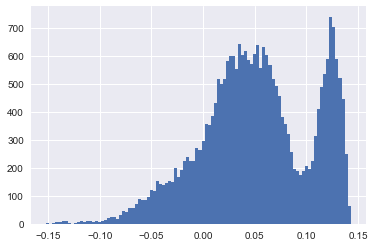

In [9]:
# the anomaly scores show 2 distinct categories
anomaly_score = pipeline.decision_function(MCLE)
MCLE['anomaly_score'] = anomaly_score
MCLE.anomaly_score.hist(bins=100)
plt.show()

In [10]:
X_test['iForest'] = pipeline.predict(X_test)
X_test["GoodBot"] = df['userAgentHttp'].str.contains("bot").astype(int)
tabs=pd.crosstab(X_test.iForest, X_test.GoodBot, margins=True)
tabs

C:\Users\sk1558\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\sk1558\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


GoodBot,0,1,All
iForest,,,
-1,430,22,452
1,2678,4,2682
All,3108,26,3134


In [13]:
# Pickle the pipeline model with iForest (train/test)
fn = pickle.dumps(model)
picpipe_iFst = pickle.loads(fn)
picpipe_iFst.predict(X_test)

array([ 1, -1,  1, ..., -1,  1,  1])